# Exploring Sentinel-2 NDVI Data

This notebook explores the Sentinel-2 NDVI data that has been downloaded and processed for the Midelt region in Morocco.

In [1]:
# Import necessary libraries
import os
import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import xarray as xr

# Set up plotting style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

## Loading Data

Let's load the processed NDVI data files.

In [2]:
# Define path to processed data
data_path = Path("../data/test_output")

# Check if the data exists
if not data_path.exists():
    print(f"Data directory not found at {data_path}")
    print("Please run the data processing script first or update the path.")
else:
    print(f"Data directory found at {data_path}")
    # List years available
    years = [d.name for d in data_path.iterdir() if d.is_dir()]
    print(f"Years available: {', '.join(sorted(years))}")

Data directory found at ../data/test_output
Years available: 2022, scenes


## Visualizing NDVI Data

Let's visualize the NDVI data for a sample scene to understand spatial patterns.

In [3]:
# Function to load NDVI data from a GeoTIFF file
def load_ndvi(file_path):
    """Load NDVI data from a GeoTIFF file."""
    try:
        # Open with rioxarray to preserve geospatial metadata
        ndvi = rxr.open_rasterio(file_path)
        return ndvi
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load summary files for scene information
summaries = {}
for year in sorted(years):
    summary_file = data_path / year / f"{year}_scenes_summary.csv"
    if summary_file.exists():
        df = pd.read_csv(summary_file)
        # Convert date strings to datetime
        df["date"] = pd.to_datetime(df["date"])
        summaries[year] = df
        print(f"Year {year}: {len(df)} scenes")

Year 2022: 12 scenes


Selected NDVI file: ../data/test_output/scenes/S2A_30SVE_20220103_0_L2A/ndvi.tif


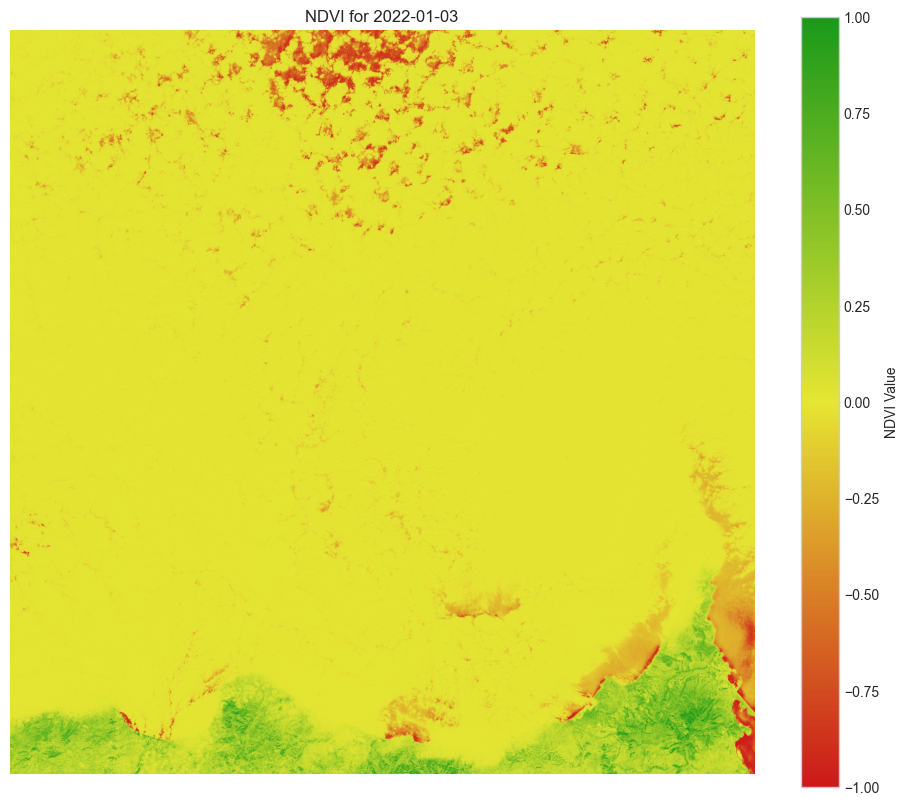

NDVI Statistics:
Min: -1.000
Max: 0.999
Mean: 0.000
Median: -0.003


In [6]:
# Find a sample NDVI file to visualize
if summaries:
    # Get the first year
    first_year = sorted(summaries.keys())[0]
    scenes = summaries[first_year]
    
    if len(scenes) > 0:
        # Select the first scene
        scene = scenes.iloc[0]
        ndvi_path = "../" +  scene["ndvi_path"]
        print(f"Selected NDVI file: {ndvi_path}")
        
        # Load the NDVI data
        ndvi_data = load_ndvi(ndvi_path)
        
        if ndvi_data is not None:
            # Plot the NDVI image
            plt.figure(figsize=(12, 10))
            
            # Set up a colormap for NDVI values
            colors = [(0.8, 0.1, 0.1), (0.9, 0.9, 0.2), (0.1, 0.6, 0.1)]
            cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("ndvi_cmap", colors, N=256)
            
            # Plot data
            plt.imshow(ndvi_data[0], cmap=cmap, vmin=-1, vmax=1)
            plt.colorbar(label="NDVI Value")
            plt.title(f"NDVI for {scene["date"].strftime("%Y-%m-%d")}")
            plt.axis("off")
            plt.show()
            
            # Show basic statistics
            ndvi_values = ndvi_data.values.flatten()
            ndvi_values = ndvi_values[~np.isnan(ndvi_values)]
            
            print(f"NDVI Statistics:")
            print(f"Min: {ndvi_values.min():.3f}")
            print(f"Max: {ndvi_values.max():.3f}")
            print(f"Mean: {ndvi_values.mean():.3f}")
            print(f"Median: {np.median(ndvi_values):.3f}")

## Time Series Analysis

Let's analyze how NDVI changes over time for our region.

In [9]:
summaries

{'2022':          date                  scene_id  \
 0  2022-01-03  S2A_30SVE_20220103_0_L2A   
 1  2022-01-05  S2B_30SVE_20220105_0_L2A   
 2  2022-01-08  S2B_30SVE_20220108_0_L2A   
 3  2022-01-10  S2A_30SVE_20220110_0_L2A   
 4  2022-01-13  S2A_30SVE_20220113_0_L2A   
 5  2022-01-15  S2B_30SVE_20220115_0_L2A   
 6  2022-01-18  S2B_30SVE_20220118_0_L2A   
 7  2022-01-20  S2A_30SVE_20220120_0_L2A   
 8  2022-01-23  S2A_30SVE_20220123_0_L2A   
 9  2022-01-25  S2B_30SVE_20220125_0_L2A   
 10 2022-01-28  S2B_30SVE_20220128_0_L2A   
 11 2022-01-30  S2A_30SVE_20220130_0_L2A   
 
                                             ndvi_path  cloud_cover mgrs_tile  
 0   data/test_output/scenes/S2A_30SVE_20220103_0_L...          NaN     30SVE  
 1   data/test_output/scenes/S2B_30SVE_20220105_0_L...          NaN     30SVE  
 2   data/test_output/scenes/S2B_30SVE_20220108_0_L...          NaN     30SVE  
 3   data/test_output/scenes/S2A_30SVE_20220110_0_L...          NaN     30SVE  
 4   data/test_out

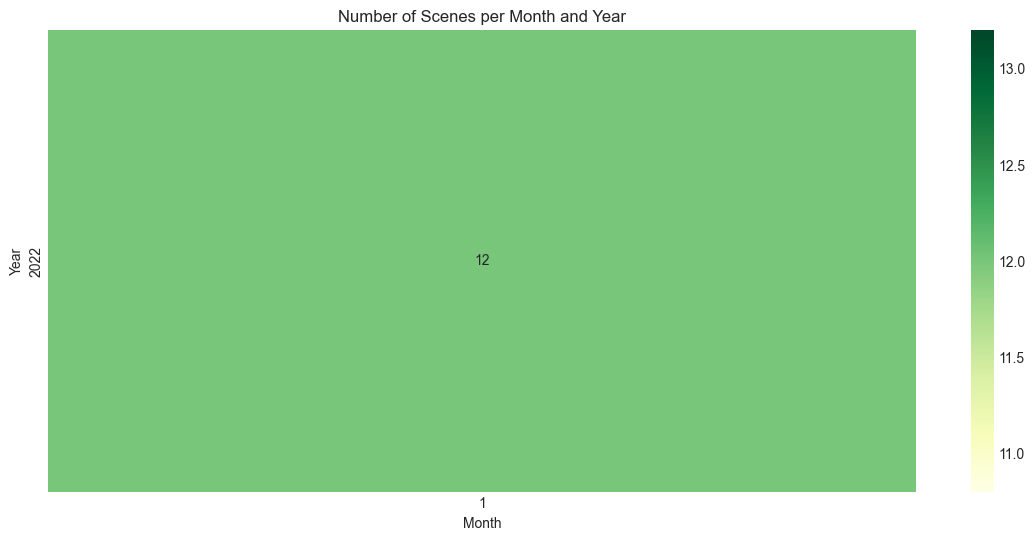

In [8]:
# Combine all data for time series analysis
all_data = pd.concat(summaries.values()) if summaries else pd.DataFrame()

if not all_data.empty:
    # Extract year and month
    all_data["year"] = all_data["date"].dt.year
    all_data["month"] = all_data["date"].dt.month
    
    # Create a plot of scene acquisition dates
    plt.figure(figsize=(14, 6))
    
    # Group by year and month
    scene_counts = all_data.groupby(["year", "month"]).size().unstack()
    
    # Plot heatmap
    sns.heatmap(scene_counts, annot=True, fmt="d", cmap="YlGn")
    plt.title("Number of Scenes per Month and Year")
    plt.ylabel("Year")
    plt.xlabel("Month")
    plt.show()

## Conclusion

We've explored the NDVI data calculated from Sentinel-2 satellite imagery. This data can be used for:

1. Monitoring vegetation health
2. Detecting changes in agricultural areas
3. Analyzing seasonal patterns
4. Identifying anomalies in vegetation growth